In [ ]:
''' 
  The Term Project Begins. Will add project description here later

'''

# **Import Libraries**

In [ ]:
# Libraries to install
!pip install nsepy

  Created wheel for nsepy: filename=nsepy-0.8-cp36-none-any.whl size=36085 sha256=8c37728239279753f61d2bd46ee480011c347f0a9b4cfd6f90bed1a588501d04
  Stored in directory: /root/.cache/pip/wheels/05/2c/72/5324e267426eea65dec0c21a12a48b15887c0cf686c7a8fe11
Successfully built nsepy


In [ ]:
# Packages to import
from nsepy import get_history as gh
import datetime as dt
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# **LSTM Model based Prediction**
For Jupyter notebook, load data from NSEpy library.\
For Google Collab, load data pre-extracted from NSEpy in .csv file

In [ ]:
  '''
=====ATTENTION=====
nsepy.get_history gets caught in a infinite loop in google collab but works perfectly in local host Jupyter notebook.
So for google colab, we import data from a csv file created from the same data on a Jupyter Notebook
===================
'''
# # For Jupyter Notebook only. Skip this cell for Google colab
# # Import data from NSEpy
# start_date = dt.datetime(2015,1,1)
# end_date = dt.datetime(2020,8,31)
# data = gh(symbol='RELIANCE',start = start_date, end = end_date)

'\n=====ATTENTION=====\nnsepy.get_history gets caught in a infinite loop in google collab but works perfectly in local host Jupyter notebook.\nSo for google colab, we import data from a csv file created from the same data on a Jupyter Notebook\n===================\n'

In [ ]:
# For Google collab, import data from github
data = pd.read_csv('https://raw.githubusercontent.com/adityajaas/CS771A_term_project/master/RELIANCE.csv')
data.set_index(pd.Index(np.linspace(1, len(data.index), len(data.index), dtype = int)))
data['Date']= pd.to_datetime(data['Date']) 
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,RELIANCE,EQ,891.15,886.3,892.00,883.65,888.00,887.90,887.62,677439,6.013059e+13,16263,286377,0.4227
1,2015-01-02,RELIANCE,EQ,887.90,888.1,896.05,884.30,884.95,885.55,889.39,1675827,1.490461e+14,31269,1048543,0.6257
2,2015-01-05,RELIANCE,EQ,885.55,885.0,890.90,874.10,875.55,875.85,881.88,2309591,2.036781e+14,67035,1393132,0.6032
3,2015-01-06,RELIANCE,EQ,875.85,870.0,873.00,832.00,832.50,836.10,847.60,4258043,3.609133e+14,120767,2353273,0.5527
4,2015-01-07,RELIANCE,EQ,836.10,837.1,858.80,837.00,858.00,854.30,849.81,4736315,4.024972e+14,125939,2885468,0.6092


Visualising the stock price data of Reliance Industries Limited (**RELIANCE**) from **January 2015** to **August 2020**. Data is plotted for the day's close price.

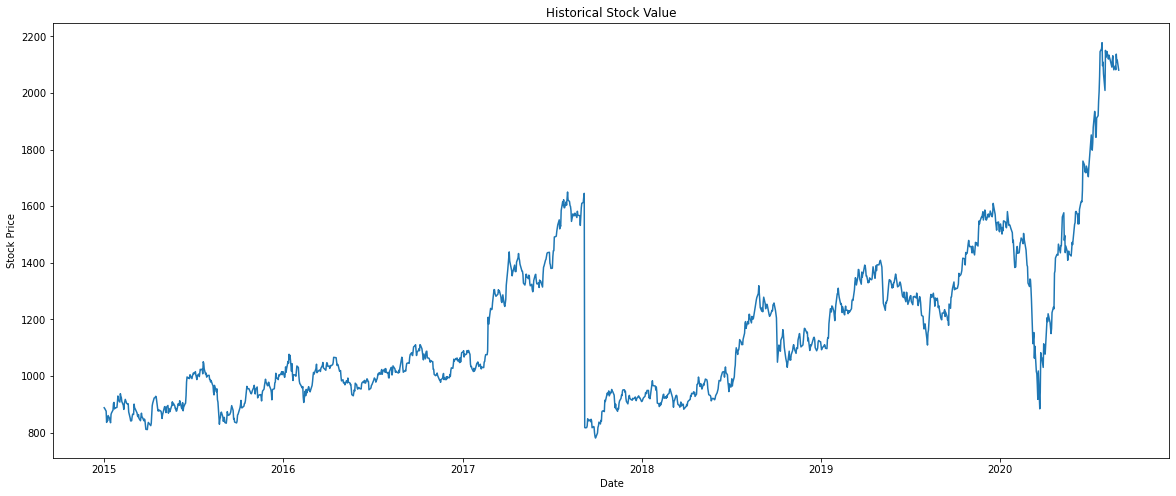

In [ ]:
# Visualize the plot
plt.figure(figsize=(20,8))
plt.plot(data['Date'],data['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

Processing the raw data to only include relevant columns in the final dataframe. Relevant columns are Date of observaton, Open price, Highest price of the day, Lowest price of the day, Close price.

In [ ]:
# Create new dataframe with only relevant columns
stk_data = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
stk_data['Date'] = data['Date']
stk_data['Open'] = data['Open']
stk_data['High'] = data['High']
stk_data['Low'] = data['Low']
stk_data['Close'] = data['Close']
stk_data.head()

,Date,Open,High,Low,Close
0,2015-01-01,886.3,892.00,883.65,887.90
1,2015-01-02,888.1,896.05,884.30,885.55
2,2015-01-05,885.0,890.90,874.10,875.85
3,2015-01-06,870.0,873.00,832.00,836.10
4,2015-01-07,837.1,858.80,837.00,854.30


After the data is cleaned, we proceed by splitting it in the ratio of 4:1 for training and testing the model respectively. After splitting, the data is normalized using its mean and standard deviation.

In [ ]:
# Define the training set
percent_training: float = 0.80
num_training_samples = int(np.ceil(percent_training*len(stk_data))) # number of training samples in int
training_set = stk_data.iloc[:num_training_samples, 4:5].values # Extract the Close values for training data

#Define the test data
num_testing_samples: int = len(stk_data) - num_training_samples # number of test samples in int 
testing_set = stk_data.iloc[-num_testing_samples:, 4:5].values # Extract the Close values for test data

In [ ]:
# Scale training data
scaler = StandardScaler() # MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set) #2D (num_training_samples, 1)
testing_set_scaled = scaler.transform(testing_set) # 2D ndarray (num_testing_samples, 1)

In [ ]:
# Create [X]_train, [X]_test and [Y]_train, [Y]_test for model training and testing

sequence_length: int = 90 # Number of x_i for each y_i

x_train = np.array([training_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(training_set_scaled))]) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # 3D training set (num_training_samples, sequence_length, 1) 

x_test = np.array([testing_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(testing_set_scaled))])
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #3D test set (num_testing_samples, sequence_length, 1)

y_train = np.array([training_set_scaled[i, 0] for i in range(sequence_length, len(training_set_scaled))]) # 2D (num_training_samples, 1)
y_test = np.array([testing_set_scaled[i, 0] for i in range(sequence_length, len(testing_set_scaled))]) # 2D (num_testing_samples, 1)
y_test = np.reshape(y_test, (y_test.shape[0])) # 1D (num_testing_samples, )

print('x_train shape:', x_train.shape, '\n', 'x_test shape:', x_test.shape, '\n', 'y_train shape:', y_train.shape, '\n', 'y_test shape:', y_test.shape)

x_train shape: (1031, 90, 1) 
 x_test shape: (190, 90, 1) 
 y_train shape: (1031,) 
 y_test shape: (190,)


#**Model Training**

In [ ]:
# Build LSTM Model
epochs: int = 80
batch_size: int = 32

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, return_sequences=False),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(16),
  tf.keras.layers.Dense(1),
])
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', 
             optimizer = 'adam', 
             )

# Early Stopping
# Check at end of every epoch whether the loss is no longer decreasing, considering the min_delta (0 by default) and patience if applicable. 
# Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, # Shows progress of each epoch
                               patience = 9, # Check for 9 more iterations after loss decrement stalls
                               restore_best_weights = False
                               )
# Loss history
loss_history = model.fit(x_train,
          y_train,
          epochs = epochs, 
          batch_size = batch_size,
          verbose = 2, 
          validation_split = 0.20,
          # validation_data = (x_test, y_test),
          callbacks = [early_stopping],
          )

model.summary() # Get model summary
loss = model.evaluate(x_test, y_test, batch_size = batch_size) # Evaluate model on test data

# early_stopping.stopped_epoch returns 0 if training didn't stop early.
if early_stopping.stopped_epoch != 0:
  print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

Epoch 1/80
26/26 - 1s - loss: 0.3333 - val_loss: 0.2154
Epoch 2/80
26/26 - 1s - loss: 0.0846 - val_loss: 0.0343
Epoch 3/80
26/26 - 1s - loss: 0.0669 - val_loss: 0.0294
Epoch 4/80
26/26 - 1s - loss: 0.0571 - val_loss: 0.0389
Epoch 5/80
26/26 - 1s - loss: 0.0509 - val_loss: 0.0254
Epoch 6/80
26/26 - 1s - loss: 0.0475 - val_loss: 0.0254
Epoch 7/80
26/26 - 1s - loss: 0.0473 - val_loss: 0.0309
Epoch 8/80
26/26 - 1s - loss: 0.0464 - val_loss: 0.0258
Epoch 9/80
26/26 - 1s - loss: 0.0418 - val_loss: 0.0238
Epoch 10/80
26/26 - 1s - loss: 0.0430 - val_loss: 0.0227
Epoch 11/80
26/26 - 1s - loss: 0.0466 - val_loss: 0.0453
Epoch 12/80
26/26 - 1s - loss: 0.0445 - val_loss: 0.0262
Epoch 13/80
26/26 - 1s - loss: 0.0497 - val_loss: 0.0399
Epoch 14/80
26/26 - 1s - loss: 0.0429 - val_loss: 0.0282
Epoch 15/80
26/26 - 1s - loss: 0.0391 - val_loss: 0.0218
Epoch 16/80
26/26 - 1s - loss: 0.0377 - val_loss: 0.0222
Epoch 17/80
26/26 - 1s - loss: 0.0388 - val_loss: 0.0217
Epoch 18/80
26/26 - 1s - loss: 0.0381 - 

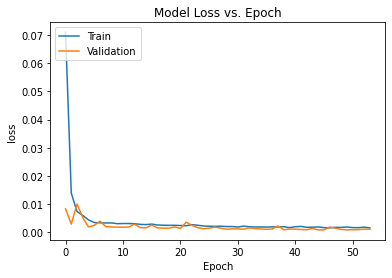

In [ ]:
plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Prediction**

In [ ]:
training_prediction = model.predict(x_train)
training_prediction = scaler.inverse_transform(training_prediction) # Get back data in unscaled (not normalized) data

train_dates = stk_data['Date'][sequence_length: sequence_length + x_train.shape[0]]

In [ ]:
test_prediction = model.predict(x_test)

y_test2 = np.reshape(y_test, (y_test.shape[0], 1))

test_dates = stk_data['Date'][-x_test.shape[0]:]

Gaps in prediction line since model requires minimum sequence length of input to predict
The MSE loss for test data: 0.2800573875731828


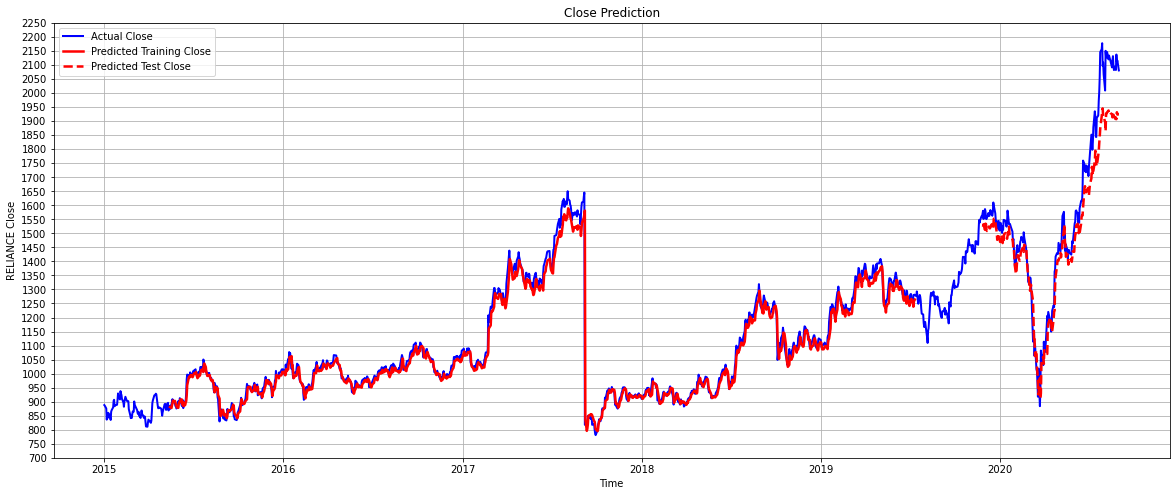

In [ ]:
print('Gaps in prediction line since model requires minimum sequence length of input to predict')

assert y_test2.shape == test_prediction.shape
print('The MSE loss for test data:', sklearn.metrics.mean_squared_error(y_test2,test_prediction))

test_prediction = scaler.inverse_transform(test_prediction) # Get back data in unscaled (not normalized) data
y_test2 = scaler.inverse_transform(y_test2) # Get back data in unscaled (not normalized) data

# Visualizing test results
plt.figure(figsize=(20,8))

plt.plot(data['Date'],data['Close'],'-', linewidth = 2, color = 'blue', label = 'Actual Close')

plt.plot(train_dates, training_prediction, '-', linewidth = 2.5 ,color = 'red', label = 'Predicted Training Close')
plt.plot(test_dates, test_prediction, '--', linewidth = 2.5 ,color = 'red', label = 'Predicted Test Close')

ax = plt.gca()

plt.title('Close Prediction')
plt.xlabel('Time')
plt.ylabel('RELIANCE Close')
plt.yticks(np.arange(700, 2300, 50))
plt.grid(True, which= 'both')
plt.legend()
plt.show()

# **MISCELLANEOUS**

Epoch 1/80
26/26 - 1s - loss: 0.0715 - val_loss: 0.0045
Epoch 2/80
26/26 - 1s - loss: 0.0125 - val_loss: 0.0035
Epoch 3/80
26/26 - 1s - loss: 0.0077 - val_loss: 0.0043
Epoch 4/80
26/26 - 1s - loss: 0.0055 - val_loss: 0.0029
Epoch 5/80
26/26 - 1s - loss: 0.0046 - val_loss: 0.0020
Epoch 6/80
26/26 - 1s - loss: 0.0039 - val_loss: 0.0017
Epoch 7/80
26/26 - 1s - loss: 0.0036 - val_loss: 0.0017
Epoch 8/80
26/26 - 1s - loss: 0.0032 - val_loss: 0.0024
Epoch 9/80
26/26 - 1s - loss: 0.0035 - val_loss: 0.0016
Epoch 10/80
26/26 - 1s - loss: 0.0037 - val_loss: 0.0016
Epoch 11/80
26/26 - 1s - loss: 0.0030 - val_loss: 0.0015
Epoch 12/80
26/26 - 1s - loss: 0.0029 - val_loss: 0.0017
Epoch 13/80
26/26 - 1s - loss: 0.0028 - val_loss: 0.0015
Epoch 14/80
26/26 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 15/80
26/26 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 16/80
26/26 - 1s - loss: 0.0030 - val_loss: 0.0019
Epoch 17/80
26/26 - 1s - loss: 0.0026 - val_loss: 0.0028
Epoch 18/80
26/26 - 1s - loss: 0.0028 - 

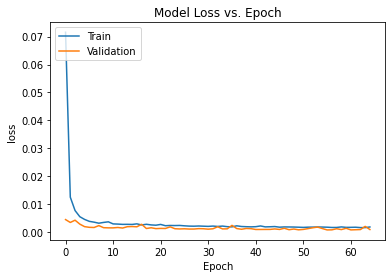

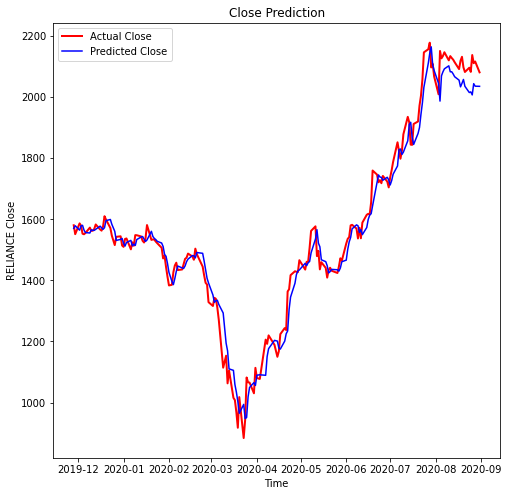

In [ ]:

# Build LSTM Model
epochs: int = 80
batch_size: int = 32

#LSTM_1 = LSTM(units = 32, #initially 5
#    activation = 'relu', #initially tanh
#   input_shape = (x_train.shape[1], 1),
#   return_sequences = False,
#   )
# LSTM_2 = LSTM(
#     units = 10,
#     input_shape = ( sequence_length, 5)
#     )
#model = Sequential()
#model.add(LSTM_1) # Output shape: (batch_size, sequence_length, units)
#model.add(Dropout(0.4))
# model.add(LSTM_2) # Output shape: 
# model.add(Dropout(0.2))
model = tf.keras.models.Sequential([
  #tf.keras.layers.LSTM(32, return_sequences=True),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(32, return_sequences=False),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(16),
  tf.keras.layers.Dense(1),
])
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', 
             optimizer = 'adam', 
             )

# Early Stopping
# Check at end of every epoch whether the loss is no longer decreasing, considering the min_delta (0 by default) and patience if applicable. 
# Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, # Shows progress of each epoch
                               patience = 9, # Check for 9 more iterations after loss decrement stalls
                               restore_best_weights = True
                               )
# Loss history
loss_history = model.fit(x_train,
          y_train,
          epochs = epochs, 
          batch_size = batch_size,
          verbose = 2, 
          validation_split = 0.20,
          # validation_data = (x_test, y_test),
          callbacks = [early_stopping],
          )

model.summary() # Get model summary
loss = model.evaluate(x_test, y_test, batch_size = batch_size) # Evaluate model on test data

# early_stopping.stopped_epoch returns 0 if training didn't stop early.
if early_stopping.stopped_epoch != 0:
  print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

#############################################################################################

plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#############################################################################################

prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction) # Get back data in unscaled (not normalized) data

y_test2 = np.reshape(y_test, (y_test.shape[0], 1))
y_test = scaler.inverse_transform(y_test2) # Get back data in unscaled (not normalized) data

test_dates = stk_data['Date'][-x_test.shape[0]:]

#############################################################################################

# Visualizing test results
plt.figure(figsize=(8,8))
plt.plot_date(test_dates, y_test, '-', linewidth = 2, color = 'red', label = 'Actual Close')
plt.plot(test_dates, prediction, color = 'blue', label = 'Predicted Close')
plt.title('Close Prediction')
plt.xlabel('Time')
plt.ylabel('RELIANCE Close')
plt.legend()
plt.show()

# **Neural ODE based prediction**
We load Data of RELIANCE stocks again. Again, we clean and normalize it.

In [ ]:
 '''
=====ATTENTION=====
nsepy.get_history gets caught in a infinite loop in google collab but works perfectly in local host Jupyter notebook.
So for google colab, we import data from a csv file created from the same data on a Jupyter Notebook
===================
'''
# For Jupyter Notebook only. Skip this cell for Google colab
# Import data from NSEpy
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2020,8,31)
data = gh(symbol='RELIANCE',start = start_date, end = end_date)

In [ ]:
# For Google collab, import data from github
data = pd.read_csv('https://raw.githubusercontent.com/adityajaas/CS771A_term_project/master/RELIANCE.csv')
data.set_index(pd.Index(np.linspace(1, len(data.index), len(data.index), dtype = int)))
data['Date']= pd.to_datetime(data['Date']) 
print(data.shape)
data.head()

(1401, 15)


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,RELIANCE,EQ,891.15,886.3,892.00,883.65,888.00,887.90,887.62,677439,6.013059e+13,16263,286377,0.4227
1,2015-01-02,RELIANCE,EQ,887.90,888.1,896.05,884.30,884.95,885.55,889.39,1675827,1.490461e+14,31269,1048543,0.6257
2,2015-01-05,RELIANCE,EQ,885.55,885.0,890.90,874.10,875.55,875.85,881.88,2309591,2.036781e+14,67035,1393132,0.6032
3,2015-01-06,RELIANCE,EQ,875.85,870.0,873.00,832.00,832.50,836.10,847.60,4258043,3.609133e+14,120767,2353273,0.5527
4,2015-01-07,RELIANCE,EQ,836.10,837.1,858.80,837.00,858.00,854.30,849.81,4736315,4.024972e+14,125939,2885468,0.6092


In [ ]:
# Create new dataframe with only relevant columns
stk_data = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
stk_data['Date'] = data['Date']
stk_data['Open'] = data['Open']
stk_data['High'] = data['High']
stk_data['Low'] = data['Low']
stk_data['Close'] = data['Close']
stk_data.head()

# Define the training set
percent_training: float = 0.80
num_training_samples = int(np.ceil(percent_training*len(stk_data))) # number of training samples in int
training_set = stk_data.iloc[:num_training_samples, 4:5].values # Extract the Close values for training data

#Define the test data
num_testing_samples: int = len(stk_data) - num_training_samples # number of test samples in int 
testing_set = stk_data.iloc[-num_testing_samples:, 4:5].values # Extract the Close values for test data

# Scale training data
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set) #2D (num_training_samples, 1)
testing_set_scaled = scaler.transform(testing_set) # 2D ndarray (num_testing_samples, 1)

print('Data cleaned, split, and normalized')

Data cleaned, split, and normalized


In [ ]:
# Create [X]_train, [X]_test and [Y]_train, [Y]_test for model training and testing

sequence_length: int = 90 # Number of x_i for each y_i

x_train = np.array([training_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(training_set_scaled))]) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # 3D training set (num_training_samples, sequence_length, 1) 

x_test = np.array([testing_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(testing_set_scaled))])
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #3D test set (num_testing_samples, sequence_length, 1)

y_train = np.array([training_set_scaled[i, 0] for i in range(sequence_length, len(training_set_scaled))]) # 2D (num_training_samples, 1)
y_test = np.array([testing_set_scaled[i, 0] for i in range(sequence_length, len(testing_set_scaled))]) # 2D (num_testing_samples, 1)
y_test = np.reshape(y_test, (y_test.shape[0])) # 1D (num_testing_samples, )

print('x_train shape:', x_train.shape, '\n', 'x_test shape:', x_test.shape, '\n', 'y_train shape:', y_train.shape, '\n', 'y_test shape:', y_test.shape)

x_train shape: (1031, 90, 1) 
 x_test shape: (190, 90, 1) 
 y_train shape: (1031,) 
 y_test shape: (190,)


In [ ]:
pip install torchdiffeq

In [ ]:
!pip install git+https://github.com/google-research/torchsde.git 
import torch
import torchsde
import timeit
class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Linear(d, 
                                  d)
        self.sigma = torch.nn.Linear(d, 
                                     d * m)

    def f(self, t, y):
        return self.mu(y)  # shape (batch_size, state_size)

    def g(self, t, y):
        return self.sigma(y).view(batch_size, 
                                  d, 
                                  m)

batch_size, d, m = 1031,90,90  # State dimension d, Brownian motion dimension m.
geometric_bm = SDE()
#y0 = torch.Tensor(x_train)  # Initial state..
ts = torch.linspace(0, 1, 20)
ys = sdeint(geometric_bm, y0, ts)

def time_func():
    ys = sdeint(geometric_bm, y0, ts, adaptive=False, dt=ts[1], options={'trapezoidal_approx': False})
    
timeit.Timer(time_func).timeit(number=100) 

  Cloning https://github.com/google-research/torchsde.git to /tmp/pip-req-build-12rj_l68
  Running command git clone -q https://github.com/google-research/torchsde.git /tmp/pip-req-build-12rj_l68
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 174kB 2.7MB/s 
     |████████████████████████████████| 14.5MB 312kB/s 
     |████████████████████████████████| 25.9MB 137kB/s 
  Created wheel for torchsde: filename=torchsde-0.2.1-cp36-none-any.whl size=54172 sha256=0884300d37e5c19b9341de683036c6d6c3ada36e44e4c57848e96cf74f9dd705
  Stored in directory: /tmp/pip-ephem-wheel-cache-fmbajzbf/wheels/31/b5/4b/53c7d7c124c1bbfebd2c5f429ca86b5e59f6cd4718dc0f1229
Successfully built torchsde
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.3 which

NameError: ignored